#Conv MNIST AE

## Installation and imports

In [7]:
!mkdir figures
!mkdir scripts
%cd /content/scripts
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/lvm_plots_utils.py
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-conv-latent-dim-2.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/ae-mnist-conv-latent-dim-20.ckpt
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/ae_mnist_conv.py

/content/scripts


In [8]:
%%capture
! pip install --quiet torchvision pytorch-lightning torch test-tube einops umap

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer
from einops import rearrange
import seaborn as sns
from lvm_plots_utils import get_random_samples, get_grid_samples, plot_scatter_plot, get_imrange, plot_grid_plot
from torchvision.utils import make_grid
from pytorch_lightning.utilities.seed import seed_everything
from ae_mnist_conv import ConvAE

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
mnist_full = MNIST(".", download=True, train=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

dm = DataLoader(mnist_full, batch_size=512, shuffle=True)

## Basic MLP VAE Module

In [19]:
ae = ConvAE((1, 28, 28), 
                encoder_conv_filters=[28,64,64],
                decoder_conv_t_filters=[64,28,1],
                latent_dim=20)
ae.load_state_dict(torch.load("ae-mnist-conv-latent-dim-20.ckpt"))
ae.to(device)

ConvAE(
  (vae): ConvAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Sequential(
      (0): Linear(in_features=1024, out_features=20, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.2, inplace=False)
    )
    (log_var_linear): Sequential(
      (0): Linear(in_features=1024, out_features=20, bias=True)
      (1): LeakyReLU(nega

In [22]:
ae2 = ConvAE((1, 28, 28), 
                encoder_conv_filters=[28,64,64],
                decoder_conv_t_filters=[64,28,1],
                latent_dim=2)
ae2.load_state_dict(torch.load("ae-mnist-conv-latent-dim-2.ckpt"))
ae2.to(device)

ConvAE(
  (vae): ConvAEModule(
    (enc_convs): ModuleList(
      (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(28, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
    (mu_linear): Linear(in_features=1024, out_features=2, bias=True)
    (log_var_linear): Linear(in_features=1024, out_features=2, bias=True)
    (decoder_linear): Linear(in_features=2, out_features=1024, bias=True)
    (dec_t_convs): ModuleList(
      (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
      (3): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (4): ConvTranspose2d(64, 28, kernel_size=(3, 3), stride=(1, 1), paddin

## Reconstruction

### ConvAE with latent dim 20

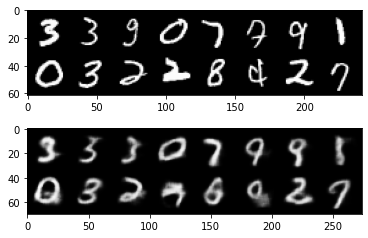

In [26]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs=plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), 'c h w -> h w c'))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(ae.vae(imgs)[0].cpu()), 'c h w -> h w c'))
plt.show()

### ConvAE with latent dim 2

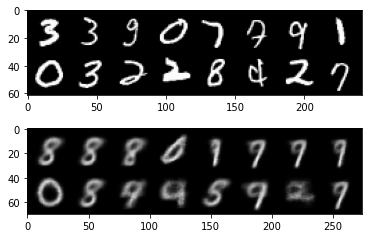

In [28]:
imgs, _ = batch
imgs = imgs[:16]

fig, axs=plt.subplots(2, 1)
axs[0].imshow(rearrange(make_grid(imgs), 'c h w -> h w c'))
imgs = imgs.to(device=device)
axs[1].imshow(rearrange(make_grid(ae2.vae(imgs)[0].cpu()), 'c h w -> h w c'))
plt.show()

## Sampling

### Random samples from truncated normal distribution 

We sample $z \sim TN(0,1)$ form a truncated normal distribution with a threshold = 5


#### ConvAE with latent dim 20

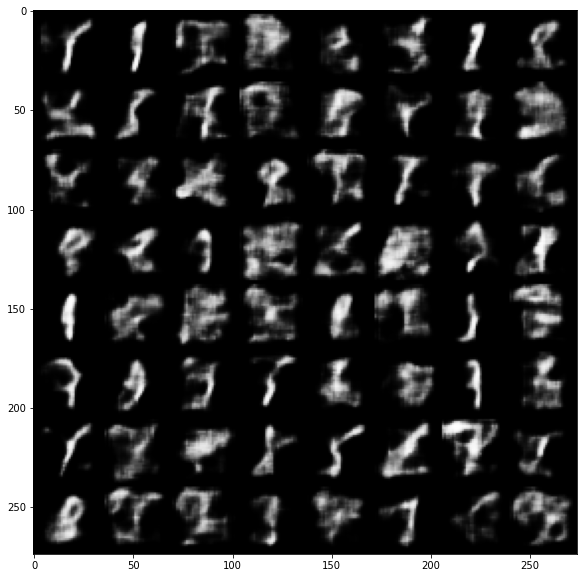

In [30]:
def decoder(z):
  return ae.vae.decode(z)

plt.figure(figsize=(10,10))
# Where 5 is the truncation threshold for our truncated normal distribution we are sampling from
imgs= get_random_samples(decoder, 5)
plt.imshow(imgs)

#### ConvAE with latent dim 2

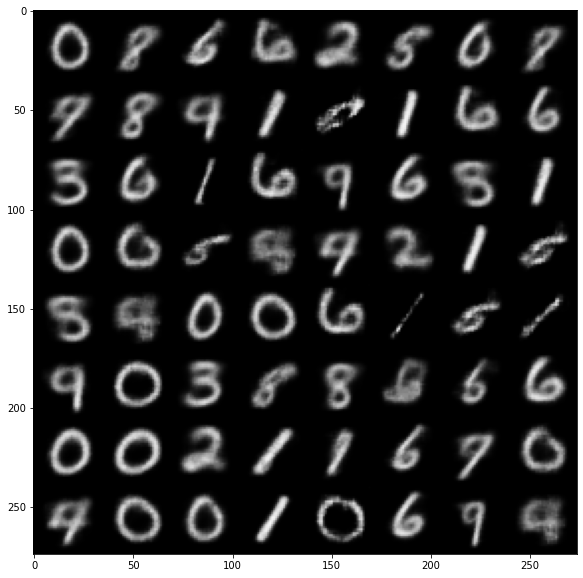

In [31]:
def decoder(z):
  return ae2.vae.decode(z)

plt.figure(figsize=(10,10))
# Where 5 is the truncation threshold for our truncated normal distribution we are sampling from
imgs= get_random_samples(decoder, 5)
plt.imshow(imgs)

### Grid Sampling

#### ConvAE with latent dim 20

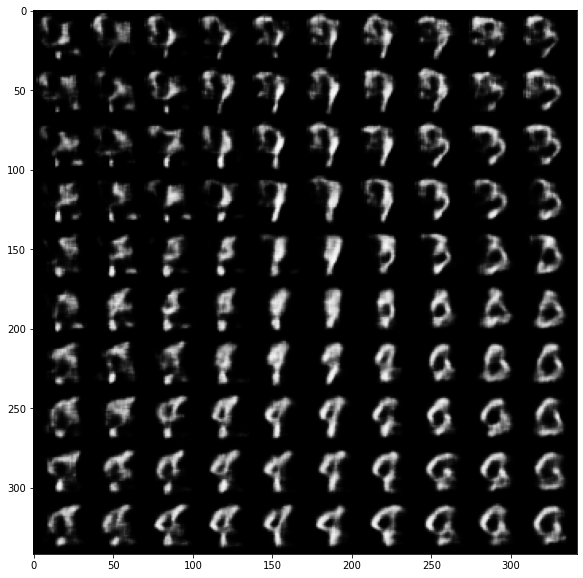

In [32]:
def decoder(z):
  return ae.vae.decode(z)[0]

plt.figure(figsize=(10,10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())

#### ConvAE with latent dim 2

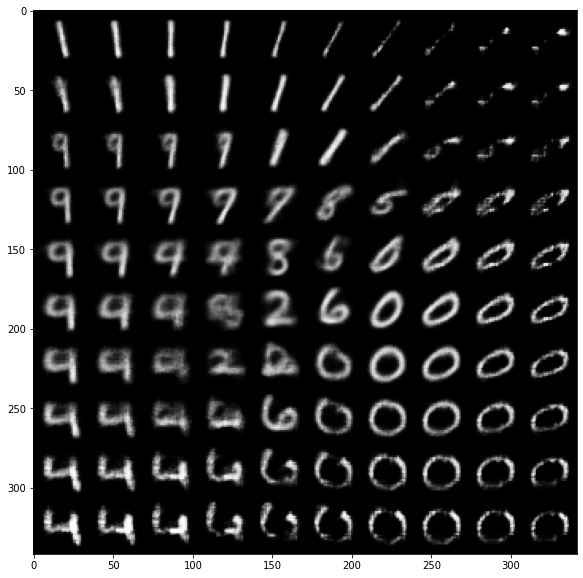

In [33]:
def decoder(z):
  return ae2.vae.decode(z)[0]

plt.figure(figsize=(10,10))
plt.imshow(rearrange(make_grid(get_grid_samples(decoder, 20), 10), " c h w -> h w c").cpu())

## 2D Color embedding of latent space

### ConvVAE with latent dim 20

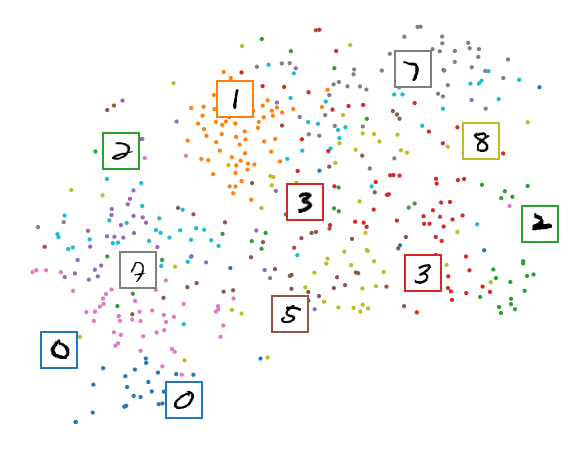

In [34]:
def encoder(img):
  return ae.vae.encode(img)[0]

def decoder(z):
  z = z.to(device)
  return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")

plot_scatter_plot(batch, encoder)

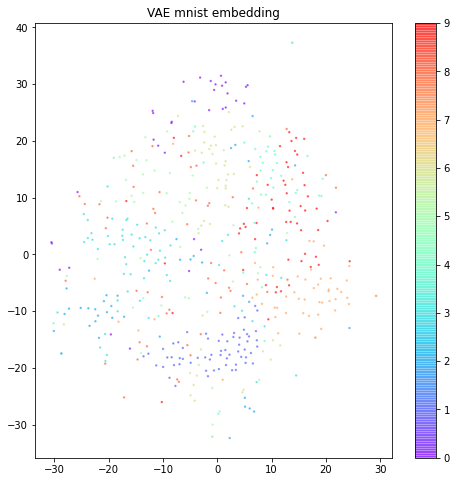

In [35]:
plot_grid_plot(batch, encoder)

### ConvAE with latent dim 2

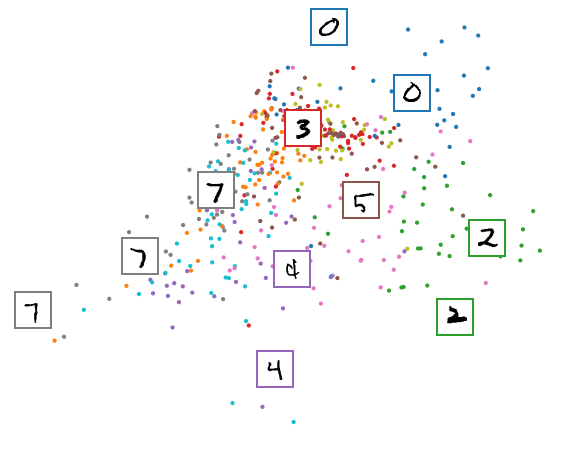

In [37]:
def encoder(img):
  return ae2.vae.encode(img)[0].cpu().detach().numpy()

def decoder(z):
  z = z.to(device)
  return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")

plot_scatter_plot(batch, encoder)

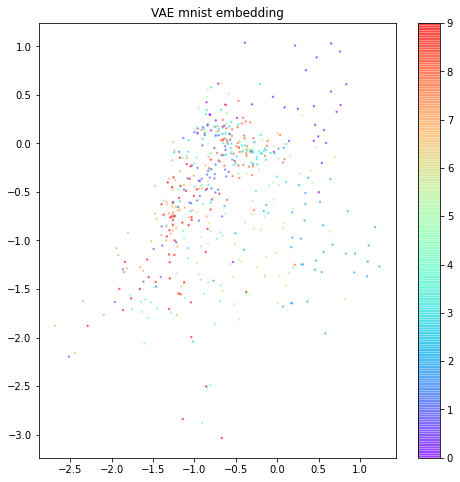

In [38]:
plot_grid_plot(batch, encoder)

## Interpolation

### Spherical Interpolation

#### ConvAE with latent dim 20

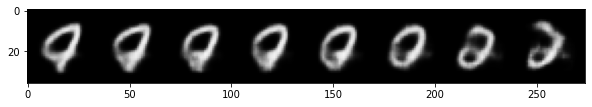

In [40]:
def decoder(z):
  z = z.to(device)
  return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")

def encoder(img):
  return ae.vae.encode(img)[0].cpu().detach()

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end)
plt.imshow(arr)

#### ConAE with latent dim 2

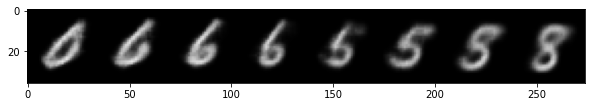

In [44]:
def decoder(z):
  z = z.to(device)
  return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")

def decoder(z):
  z = z.to(device)
  return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end, interpolation="linear")
plt.imshow(arr)

### Linear Interpolation

#### ConvAE with latent dim 20

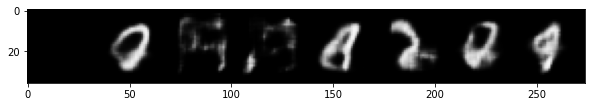

In [45]:
def decoder(z):
  z = z.to(device)
  return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")

def decoder(z):
  z = z.to(device)
  return rearrange(ae.vae.decode(z), "b c h w -> b (c h) w")

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end, interpolation="linear")
plt.imshow(arr)

#### ConvAE with latent dim 2

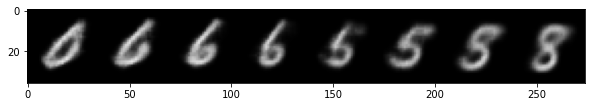

In [46]:
def decoder(z):
  z = z.to(device)
  return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")

def decoder(z):
  z = z.to(device)
  return rearrange(ae2.vae.decode(z), "b c h w -> b (c h) w")

imgs, _ = batch
imgs = imgs.to(device)
z_imgs = encoder(imgs)
end, start = z_imgs[1], z_imgs[3]

plt.figure(figsize=(10,100))
arr = get_imrange(decoder,start,end, interpolation="linear")
plt.imshow(arr)